In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

import optuna

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_path='/content/drive/MyDrive/minipjt34/'

In [9]:
# 데이터를 불러옵니다.
train =pd.read_csv(base_path + 'train_V2.csv')
test = pd.read_csv(base_path + 'test_V2.csv')
submission = pd.read_csv(base_path + 'sample_submission_V2.csv')

In [10]:
feature_reducing = "feature_importance"

In [11]:
temp1=train.copy()

In [12]:
#데이터크기축소
temp1=temp1.sample(int(len(temp1)/7), random_state=42)

In [13]:
len(temp1)

635280

In [14]:
def seek_bug_group_min(temp, match, min_num):

    group_i = temp.loc[temp.matchType == match,:]

    min_i = group_i[group_i['numGroups']<min_num]

    return min_i


def seek_bug_group_max(temp, match, max_num):

    group_i = temp.loc[temp.matchType == match,:]

    max_i = group_i[group_i['numGroups']>max_num]

    return max_i

# squad min bug
squad_min_bug = seek_bug_group_min(temp1, 'squad', 25)
squad_fpp_min_bug = seek_bug_group_min(temp1, 'squad-fpp', 25)
normal_squad_fpp_min_bug = seek_bug_group_min(temp1, 'normal-squad-fpp', 25)
normal_squad_min_bug = seek_bug_group_min(temp1, 'normal-squad', 25)

# duo min bug
duo_min_bug = seek_bug_group_min(temp1, 'duo', 44)
duo_fpp_min_bug = seek_bug_group_min(temp1, 'duo-fpp', 44)
normal_duo_fpp_min_bug = seek_bug_group_min(temp1, 'normal-duo-fpp', 44)
normal_duo_min_bug = seek_bug_group_min(temp1, 'normal-duo', 44)


# solo min bug
solo_fpp_min_bug = seek_bug_group_min(temp1, 'solo-fpp', 85)
solo_min_bug = seek_bug_group_min(temp1, 'solo', 85)
normal_solo_fpp_min_bug = seek_bug_group_min(temp1, 'normal-solo-fpp', 85)
normal_solo_min_bug = seek_bug_group_min(temp1, 'normal-solo', 85)

# squad max bug
squad_max_bug = seek_bug_group_max(temp1, 'squad', 32)
squad_fpp_max_bug = seek_bug_group_max(temp1, 'squad-fpp', 32)
normal_squad_fpp_max_bug = seek_bug_group_max(temp1, 'normal-squad-fpp', 32)
normal_squad_max_bug = seek_bug_group_max(temp1, 'normal-squad', 32)

# duo max bug
duo_max_bug= seek_bug_group_max(temp1, 'duo', 50)
duo_fpp_max_bug = seek_bug_group_max(temp1, 'duo-fpp', 50)
normal_duo_fpp_max_bug = seek_bug_group_max(temp1, 'normal-duo-fpp', 50)
normal_duo_max_bug = seek_bug_group_max(temp1, 'normal-duo', 50)

# solo max bug
solo_max_bug = seek_bug_group_max(temp1, 'solo', 100)
solo_fpp_max_bug = seek_bug_group_max(temp1, 'solo-fpp', 100)
normal_solo_fpp_max_bug = seek_bug_group_max(temp1, 'normal-solo-fpp', 100)
normal_solo_max_bug = seek_bug_group_max(temp1, 'normal-solo', 100)
# squad min bug
print(squad_min_bug,
'================================',
squad_fpp_min_bug,
'================================',
normal_squad_fpp_min_bug,
'================================',
normal_squad_min_bug, 
'================================',sep='\n')

# duo min bug
print(duo_min_bug,
'================================',
duo_fpp_min_bug,
'================================',
normal_duo_fpp_min_bug,
'================================',
normal_duo_min_bug,
'================================',sep='\n')


# solo min bug
print(solo_fpp_min_bug,
'================================',
solo_min_bug,
'================================',
normal_solo_fpp_min_bug,
'================================',
normal_solo_min_bug, 
'================================',sep='\n')

# squad max bug
print(squad_max_bug,
'================================',
squad_fpp_max_bug,
'================================',
normal_squad_fpp_max_bug,
'================================',
normal_squad_max_bug, 
'================================',sep='\n')

# duo max bug
print(duo_max_bug,
'================================',
duo_fpp_max_bug,
'================================',
normal_duo_fpp_max_bug,
'================================',
normal_duo_max_bug, 
'================================',sep='\n')

# solo max bug
print(solo_max_bug,
'================================',
solo_fpp_max_bug,
'================================',
normal_solo_fpp_max_bug,
'================================',
normal_solo_max_bug, 
'================================',sep='\n')

                     Id         groupId         matchId  assists  boosts  \
2555773  36d45a7e95b913  916c4c31723cdb  7b572f22974581        0       0   
1543844  8e7f2a3768cab0  abcec154c3e827  c30c0c9395c1cf        0       0   
2558403  f5dfe3129e22b7  d57d36822cf5b4  be37d658d8f1c8        0       0   
2187261  e8abdaf1980a3d  4174ad99cc6ac0  6e52d6cedd73f2        0       0   
3728210  f8e1d7d9b1bf5c  bbd8ca74d86239  b74a3d26827f94        0       1   
...                 ...             ...             ...      ...     ...   
82972    f5c22eb11810c8  d1ff2f9c97d1de  3321029f9dd4aa        0       1   
1230948  180c64ccfe7b88  751a602c1bdc38  02f1728faf8b84        0       1   
2801302  79578c57673be3  6d3f13d9cc7560  bc5890e157e81b        0       7   
253688   436999770695f1  4a226e8982e1c1  d604f64dc60cce        0       1   
1843119  d431942cd8f349  0035bb039d3ba1  9ebff2dcac7843        0       1   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2555773  

In [15]:
temp_1_min = pd.concat([squad_min_bug, squad_fpp_min_bug, normal_squad_fpp_min_bug, normal_squad_min_bug,
                    duo_min_bug, duo_fpp_min_bug, normal_duo_fpp_min_bug, normal_duo_min_bug, 
                    solo_fpp_min_bug, solo_min_bug, normal_solo_fpp_min_bug, normal_solo_min_bug], axis=0)
temp1_max = pd.concat([squad_max_bug, squad_fpp_max_bug, normal_squad_fpp_max_bug, normal_squad_max_bug,
                      duo_max_bug, duo_fpp_max_bug, normal_duo_fpp_max_bug, normal_duo_max_bug, 
                      solo_max_bug, solo_fpp_max_bug, normal_solo_fpp_max_bug, normal_solo_max_bug], axis=0)
temp_bug = pd.concat([temp1_max, temp_1_min], axis=0)
temp2=temp1.drop(temp_bug.index, axis=0)

In [16]:
#결측치 제거 데이터 전과 후
print(temp1.shape , temp2.shape)

(635280, 29) (578488, 29)


In [17]:
# 이벤트 제거
temp2 = temp2.drop(temp2[temp2.matchType.str.contains("flare")].index, axis=0)
temp2 = temp2.drop(temp2[temp2.matchType.str.contains("crash")].index, axis=0)
temp2

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4289863,ab772932dc284b,6f0931849c42fc,7558d7990b8795,0,0,161.30,3,2,0,7,...,1,0.0,0,0.0,0,0,565.30,2,1660,0.3929
1660760,eae2ba6cc7de4c,a8ddca0c7e8f74,0cf8e1dc70559e,0,2,100.00,0,0,1,24,...,0,450.7,0,0.0,0,0,1607.00,6,1593,0.7083
363725,aa5867db86503b,76d57fc80f70f2,fc69844a437eae,3,2,289.90,2,0,9,14,...,1,3950.0,0,0.0,0,0,2131.00,5,0,0.8148
1073463,9ec6c0ee672370,78935f8da2a64d,8a6b99c6d832f1,1,0,179.50,1,0,0,69,...,1,0.0,0,0.0,0,0,837.60,4,0,0.3333
414963,59f1f08405cf55,45bd8c2766b800,d39627df3d2674,0,0,114.80,0,0,0,71,...,0,0.0,0,0.0,0,0,187.40,2,1526,0.3214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4403242,ef9054c7b06182,a5d0e5e7272c2b,f73c14c7992c00,1,0,98.22,1,0,0,73,...,1,0.0,0,0.0,0,0,203.10,2,1392,0.2857
1350419,52142d4283c07d,86567b3d6d6a23,833b09018873ba,0,0,160.50,1,0,0,56,...,0,0.0,0,0.0,0,0,1074.00,3,1539,0.5000
3315507,90353662a089bf,78d91c5b4e8e55,81b7834ecf4f89,0,0,228.10,0,0,0,22,...,0,0.0,0,0.0,0,0,50.46,1,0,0.1000
2316104,9edc6e4b2d160d,2dbc7af0f91316,508a8f0cbab640,0,0,79.02,0,0,2,82,...,0,0.0,0,0.0,0,0,91.64,2,0,0.1489


In [18]:
temp1=temp2.copy()

In [19]:
temp2 = temp1.iloc[:,3:]
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(temp2['matchType'])
encoder.fit(test["matchType"])
temp2['matchType'] = encoder.transform(temp2['matchType'])
test['matchType'] = encoder.transform(test['matchType'])

In [20]:
trainX = temp2.drop(['winPlacePerc','killPlace'], axis=1)
testX = test.drop(columns='killPlace').iloc[:,3:]
y = temp2.winPlacePerc
print(trainX.shape, testX.shape, y.shape)

(577051, 24) (1934174, 24) (577051,)


In [21]:
# 1. correlation

# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        # 해당 row는 이미 처리가 되어서 볼 필요가 없다.
        if idx in candidate_cols:
            continue
        #print(row[row > 0.7].index[1:])
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면,
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.005]
    return important_features
    
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA
    # training data와 test data를 모두 PCA를 이용하여 차원 감소를 수행합니다.
    pca = PCA(n_components=0.90) # 원래 데이터의 90%를 보존하는 차원.
    pca_090 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_090.transform(X)
    print(reduced_X.shape)
    
    if show_plot:
        labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
        pca_090_variance = np.round(pca_090.explained_variance_ratio_.cumsum()*100, decimals=1)
        plt.figure(figsize=(25,5))
        plt.bar(x=range(1, len(pca_090_variance)+1), height=pca_090_variance, tick_label=labels)

        plt.xticks(rotation=90, color='indigo', size=15)
        plt.yticks(rotation=0, color='indigo', size=15)
        plt.title('Scree Plot',color='tab:orange', fontsize=25)
        plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
        plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
        plt.show()
        
        X_train_pca_df = pd.DataFrame(reduced_X, columns=labels)
        display(X_train_pca_df)

    return pca_090, X_train_pca_df

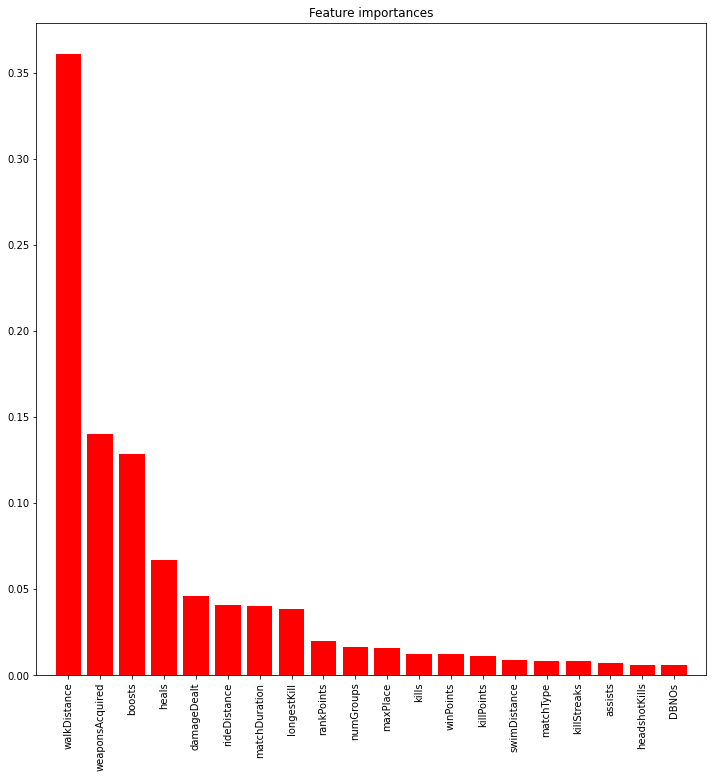

(577051, 20)


In [22]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

In [23]:
#이작업이 필요없나?
# trainX=trainX[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
#        'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
#        'matchType', 'maxPlace', 'numGroups', 'rankPoints', 'rideDistance',
#        'swimDistance', 'walkDistance', 'weaponsAcquired', 'winPoints']]
# testX=testX[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
#        'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
#        'matchType', 'maxPlace', 'numGroups', 'rankPoints', 'rideDistance',
#        'swimDistance', 'walkDistance', 'weaponsAcquired', 'winPoints']]

In [24]:
print(trainX.shape, testX.shape, y.shape)

(577051, 24) (1934174, 24) (577051,)


In [25]:
### 4. 학습 데이터 분할

In [26]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(461640, 20) (115411, 20) (461640,) (115411,)


In [27]:
### 5. 학습 및 평가 (debugging 용도)

In [28]:
print("\nFitting Random Forest...")
model = RandomForestRegressor(max_features='sqrt', n_jobs=-1)
model.fit(X_train, y_train)


Fitting Random Forest...


RandomForestRegressor(max_features='sqrt', n_jobs=-1)

In [29]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import mean_absolute_error
evaluation_metric = mean_absolute_error

In [30]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.0342
Test Score : 0.0921


In [31]:
### 6. Hyper-parameter Tuning
#- optuna를 갈아넣습니다!

In [32]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [ ]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize") # regression task에서 R^2를 최대화!
rf_study.optimize(opt_func, n_trials=13)

[I 2022-06-10 13:31:34,134] A new study created in memory with name: RF
[I 2022-06-10 13:42:52,093] Trial 0 finished with value: 0.09174614182930212 and parameters: {'n_estimators': 149, 'max_depth': 29, 'max_features': 'log2'}. Best is trial 0 with value: 0.09174614182930212.


In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
rf_study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(rf_study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(rf_study)

In [ ]:
### 7. 테스트 및 제출 파일 생성

In [ ]:
final_rf_model = RandomForestRegressor(n_estimators=rf_study.best_trial.params["n_estimators"],
                                 max_depth=rf_study.best_trial.params["max_depth"],
                                 max_features=rf_study.best_trial.params["max_features"])

final_rf_model.fit(X, y) # finalize model

In [ ]:
testX

In [ ]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)

In [ ]:
prediction = final_rf_model.predict(test)
prediction

In [ ]:
submission

In [ ]:
submission["winPlacePerc"] = prediction
submission

In [ ]:
submission.reset_index(drop=True).to_csv(f"rf_submission_{feature_reducing}.csv", index=False)